In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codecs 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,confusion_matrix
import lightgbm as lgb


In [254]:
with codecs.open('ks-projects-201612.csv',"r","Shift_JIS","ignore") as file:
    df_16 = pd.read_csv(file,delimiter=',')

df_16.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [255]:
df_18.info()
df_18.isnull().sum()
# name,categoryに欠損5件、Unnamedは欠損の多さから機能してない列として認識してよい？
# プロジェクトの遂行にIDやnameは関係ない、unnamedと併せて削除する

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [256]:
# 先ほどの列を削除
df = df_16.drop(['ID ','name ','Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16'],axis=1)
df.head()

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375


In [257]:
# 目的変数の構成について調べる,余計な値が多い
df['state '].unique()
df.groupby(['state ']).size()

state 
0                 96
1                 15
10                10
100                8
1010               1
               ...  
failed        168221
live            4428
successful    113081
suspended       1479
undefined       3555
Length: 410, dtype: int64

In [258]:
# failed,successful以外を削除し、stateについてのダミー変数処理を行う
df2 = df[(df['state '] == 'successful') | (df['state '] == 'failed') ]
df_state = pd.get_dummies(df2['state '])
df = pd.concat([df2,df_state],axis = 1 )
# successfulをstateに置き換える
df['state '] = df['successful']
df.drop(['failed','successful'],axis= 1,inplace = True)
df

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,0,0,GB,0
1,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,0,3,US,220
2,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,0,1,US,1
4,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,1,224,US,52375
5,Food,Food,USD,2014-12-21 18:30:44,1000,2014-12-01 18:30:44,1205,1,16,US,1205
...,...,...,...,...,...,...,...,...,...,...,...
323743,Documentary,Film & Video,USD,2012-03-16 03:31:10,1700,2012-02-15 04:31:10,25,0,1,US,25
323746,Narrative Film,Film & Video,USD,2011-07-19 03:35:14,1500,2011-06-22 03:35:14,155,0,5,US,155
323747,Narrative Film,Film & Video,USD,2010-08-16 05:59:00,15000,2010-07-01 19:40:30,20,0,1,US,20
323748,Technology,Technology,USD,2016-02-13 02:00:00,15000,2016-01-13 18:13:53,200,0,6,US,200


In [259]:
# 開始時期と終了時期自体は用いずに、deadlineとlaunchedの差を日数についての情報とする
df['deadline '] = pd.to_datetime(df['deadline '],errors = 'coerce')
df['launched '] = pd.to_datetime(df['launched '],errors = 'coerce')

df['period'] = (df['deadline '] - df['launched ']).dt.days
df.drop(['deadline ','launched '],axis= 1,inplace = True)
df.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,period
0,Poetry,Publishing,GBP,1000,0,0,0,GB,0,58
1,Narrative Film,Film & Video,USD,45000,220,0,3,US,220,45
2,Music,Music,USD,5000,1,0,1,US,1,30
4,Restaurants,Food,USD,50000,52375,1,224,US,52375,35
5,Food,Food,USD,1000,1205,1,16,US,1205,20


In [260]:
# dfについて情報を再度確認する,
df.info()
# goal,pledged,backers usd pledgedが数値なのにobjectであることからfloatに変換する
df['goal '] = pd.to_numeric(df['goal '])
df['pledged '] = pd.to_numeric(df['pledged '])
df['usd pledged '] = pd.to_numeric(df['usd pledged '])
df['backers '] = pd.to_numeric(df['backers '])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281302 entries, 0 to 323749
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   category        281302 non-null  object
 1   main_category   281302 non-null  object
 2   currency        281302 non-null  object
 3   goal            281302 non-null  object
 4   pledged         281302 non-null  object
 5   state           281302 non-null  uint8 
 6   backers         281302 non-null  object
 7   country         281302 non-null  object
 8   usd pledged     281092 non-null  object
 9   period          281302 non-null  int64 
dtypes: int64(1), object(8), uint8(1)
memory usage: 21.7+ MB


In [261]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281302 entries, 0 to 323749
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   category        281302 non-null  object 
 1   main_category   281302 non-null  object 
 2   currency        281302 non-null  object 
 3   goal            281302 non-null  float64
 4   pledged         281302 non-null  float64
 5   state           281302 non-null  uint8  
 6   backers         281302 non-null  int64  
 7   country         281302 non-null  object 
 8   usd pledged     281092 non-null  float64
 9   period          281302 non-null  int64  
dtypes: float64(3), int64(2), object(4), uint8(1)
memory usage: 21.7+ MB


,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,period
0,Poetry,Publishing,GBP,1000.0,0.0,0,0,GB,0.0,58
1,Narrative Film,Film & Video,USD,45000.0,220.0,0,3,US,220.0,45
2,Music,Music,USD,5000.0,1.0,0,1,US,1.0,30
4,Restaurants,Food,USD,50000.0,52375.0,1,224,US,52375.0,35
5,Food,Food,USD,1000.0,1205.0,1,16,US,1205.0,20


In [263]:
# ダミー変数の作成と結合
df = pd.concat([df
            ,pd.get_dummies(df['category '])
            ,pd.get_dummies(df['main_category '])
            ,pd.get_dummies(df['currency '])
            ,pd.get_dummies(df['country '])],axis = 1)



In [264]:
df.fillna(0)
# ダミー変数に変換したcategory,main_category,currency,countryに加え、プロジェクト開始後に得られる値であるstate,backers,pledged,usd pledgedを除外
X = df.drop(['category ','main_category ','currency ','backers ','pledged ','usd pledged ','country ','state '],axis = 1)
Y = df['state ']

In [265]:
# 扱いやすいようにindex値の修正
X = X.reset_index()
Y = Y.reset_index()

In [266]:
X

,index,goal,period,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,...,IT,LU,MX,"N,""0",NL,NO,NZ,SE,SG,US
0,0,1000.0,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,45000.0,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,5000.0,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,50000.0,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1000.0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281297,323743,1700.0,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
281298,323746,1500.0,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
281299,323747,15000.0,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
281300,323748,15000.0,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [267]:
# 古いindexの列を削除
X.drop('index',axis=1,inplace = True)
Y.drop('index',axis=1,inplace = True)
X

,goal,period,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,...,IT,LU,MX,"N,""0",NL,NO,NZ,SE,SG,US
0,1000.0,58,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,45000.0,45,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5000.0,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,50000.0,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1000.0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281297,1700.0,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
281298,1500.0,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
281299,15000.0,45,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
281300,15000.0,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [268]:
# min_maxで正規化
mm = preprocessing.MinMaxScaler()
X = mm.fit_transform(X)
X


array([[9.99990000e-06, 6.26373626e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49999900e-04, 4.83516484e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.99999000e-05, 3.18681319e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.49999900e-04, 4.83516484e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.49999900e-04, 3.18681319e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.99999000e-05, 2.96703297e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [269]:
# ホールドアウト法を行う
test_size = 0.2
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=test_size)

In [270]:
# サイズ把握
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(225041, 210)
(56261, 210)
(225041, 1)
(56261, 1)


In [275]:
# 今回はLightGBMを用いてモデル作成を行う

params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'multiclass',
    'num_class':2, # クラスの数は二値
    'verbose':2
    
    
}
lgb_train = lgb.Dataset(
    X_train,
    y_train
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    reference=lgb_train
)

lgb_results = {}
gbm = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train,lgb_test],
    valid_names=['Train','Test'],
    num_boost_round=150,
    early_stopping_rounds=10,
    evals_result=lgb_results

)




[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.977612
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.871935
[LightGBM] [Debug] init for col-wise cost 0.030555 seconds, init for row-wise cost 0.025086 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 225041, number of used features: 207
[LightGBM] [Info] Start training from score -0.514146
[LightGBM] [Info] Start training from score -0.911331
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[1]	Train's multi_logloss: 0.663553	Test's multi_logloss: 0.663595
Training until validation scores don't improve for 10 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[Lig

[40]	Train's multi_logloss: 0.588425	Test's multi_logloss: 0.589043
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[41]	Train's multi_logloss: 0.588116	Test's multi_logloss: 0.588788
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[42]	Train's multi_logloss: 0.587799	Test's multi_logloss: 0.588538
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 26
[43]	Train's multi_logloss: 0.587503	Test's multi_logloss: 0.588303
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[44]	Train's multi_logloss: 0.587235	Test's multi_logloss: 0.588072
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a t

[80]	Train's multi_logloss: 0.581332	Test's multi_logloss: 0.583645
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[81]	Train's multi_logloss: 0.581247	Test's multi_logloss: 0.583602
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[82]	Train's multi_logloss: 0.581168	Test's multi_logloss: 0.583581
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[83]	Train's multi_logloss: 0.581053	Test's multi_logloss: 0.583521
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[84]	Train's multi_logloss: 0.580938	Test's multi_logloss: 0.583453
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[123]	Train's multi_logloss: 0.578181	Test's multi_logloss: 0.582299
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[124]	Train's multi_logloss: 0.578126	Test's multi_logloss: 0.582296
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[125]	Train's multi_logloss: 0.578056	Test's multi_logloss: 0.582263
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 11
[126]	Train's multi_logloss: 0.577994	Test's multi_logloss: 0.582254
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 10
[127]	Train's multi_logloss: 0.577948	Test's multi_logloss: 0.58224
[LightGBM] [Debug] Trained

150


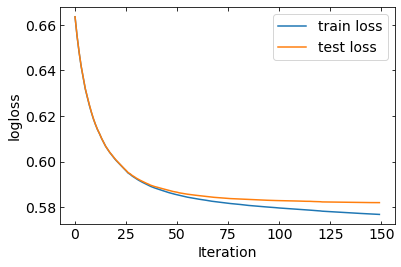

In [276]:
loss_train = lgb_results['Train']['multi_logloss']  # 訓練誤差
loss_test = lgb_results['Test']['multi_logloss']    # 汎化誤差
best_iteration = gbm.best_iteration            
print(best_iteration)
 
# 学習状況についてグラフ描画

plt.rcParams['font.size'] = 14

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
 
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
 

ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')

plt.legend()
plt.show()
plt.close()

In [277]:
# 簡易的な混同行列の作成
preds = gbm.predict(X_test)
y_pred = []
for x in preds:
    y_pred.append(np.argmax(x))
confusion_matrix(y_test,y_pred)


array([[27180,  6464],
       [11131, 11486]], dtype=int64)

In [279]:
# 正答率、適合率、再現率、F1値についても表示
precision ,recall,f1_score,_ = precision_recall_fscore_support(y_test,y_pred) 
accuracy = accuracy_score(y_test,y_pred)
print('正答率(accuracy) = {:.4f}%'.format(100 * accuracy))
print('適合率(precision) = {:.4f}%'.format(100 * precision[0]))
print('再現率(recall) = {:.4f}%'.format(100 * recall[0]))
print('F1値 = {:.4f}%'.format(100 * f1_score[0]))




正答率(accuracy) = 68.7261%
適合率(precision) = 70.9457%
再現率(recall) = 80.7871%
F1値 = 75.5472%
